 101833 Mwaniki George Ng'ang'a ICS 4B<br/>
 Dataset: https://www.kaggle.com/c/tweet-sentiment-extraction/data

In [148]:
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [149]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv')

In [150]:
train.head(2)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [151]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [152]:
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


In [153]:
train["selected_text"].isnull().sum()

1

In [154]:
train["selected_text"].fillna("No content", inplace = True)

In [155]:
def clean_data(data):
    
    #Remove URLs 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove single quotes
    data = re.sub("\'", "", data)
        
    return data

In [156]:
temp = []
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [157]:
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        

data_words = list(sentence_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [158]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [159]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [160]:
data = np.array(data)

In [161]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [162]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [163]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))


20610 6871 20610 6871


In [165]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))
model0.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint0 = ModelCheckpoint("model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
645/645 [==============================] - 31s 46ms/step - loss: 0.7350 - accuracy: 0.7113 - val_loss: 0.5424 - val_accuracy: 0.7964

Epoch 00001: val_accuracy improved from -inf to 0.79639, saving model to model.hdf5
Epoch 2/5
645/645 [==============================] - 30s 46ms/step - loss: 0.4392 - accuracy: 0.8410 - val_loss: 0.4809 - val_accuracy: 0.8077

Epoch 00002: val_accuracy improved from 0.79639 to 0.80774, saving model to model.hdf5
Epoch 3/5
645/645 [==============================] - 30s 46ms/step - loss: 0.3501 - accuracy: 0.8733 - val_loss: 0.4919 - val_accuracy: 0.8204

Epoch 00003: val_accuracy improved from 0.80774 to 0.82040, saving model to model.hdf5
Epoch 4/5
645/645 [==============================] - 30s 46ms/step - loss: 0.2935 - accuracy: 0.8965 - val_loss: 0.5257 - val_accuracy: 0.8079

Epoch 00004: val_accuracy did not improve from 0.82040
Epoch 5/5
645/645 [==============================] - 29s 46ms/step - loss: 0.2506 - accuracy: 0.9136 - val_loss

In [166]:
model = keras.models.load_model("model.hdf5")

In [168]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 2s - loss: 0.4919 - accuracy: 0.8204
Model accuracy:  0.820404589176178


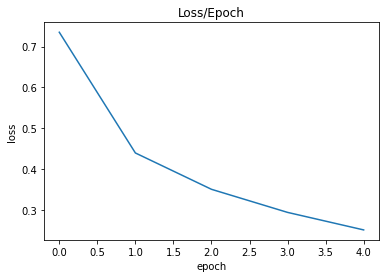

In [173]:
plt.plot(history.history["loss"])
plt.title('Loss/Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [169]:
predictions = model.predict(X_test)

In [170]:
sentiment = ['Neutral','Negative','Positive']

In [171]:
sequence = tokenizer.texts_to_sequences(['The experience was poor ,I want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [172]:
sequence = tokenizer.texts_to_sequences(['Today will be a great day'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'